In [5]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from skimage.transform import rotate
import pims, sys
from pathlib import Path
from scipy.interpolate import UnivariateSpline
sys.path.insert(0, r'C:\\Warwick\\Jerko_Code_And_Docs\\Manuscript Code')
from Filament_Analysis.geometric_2 import SimpleSpline
from pathlib import Path
import pandas as pd
import trackpy as tp

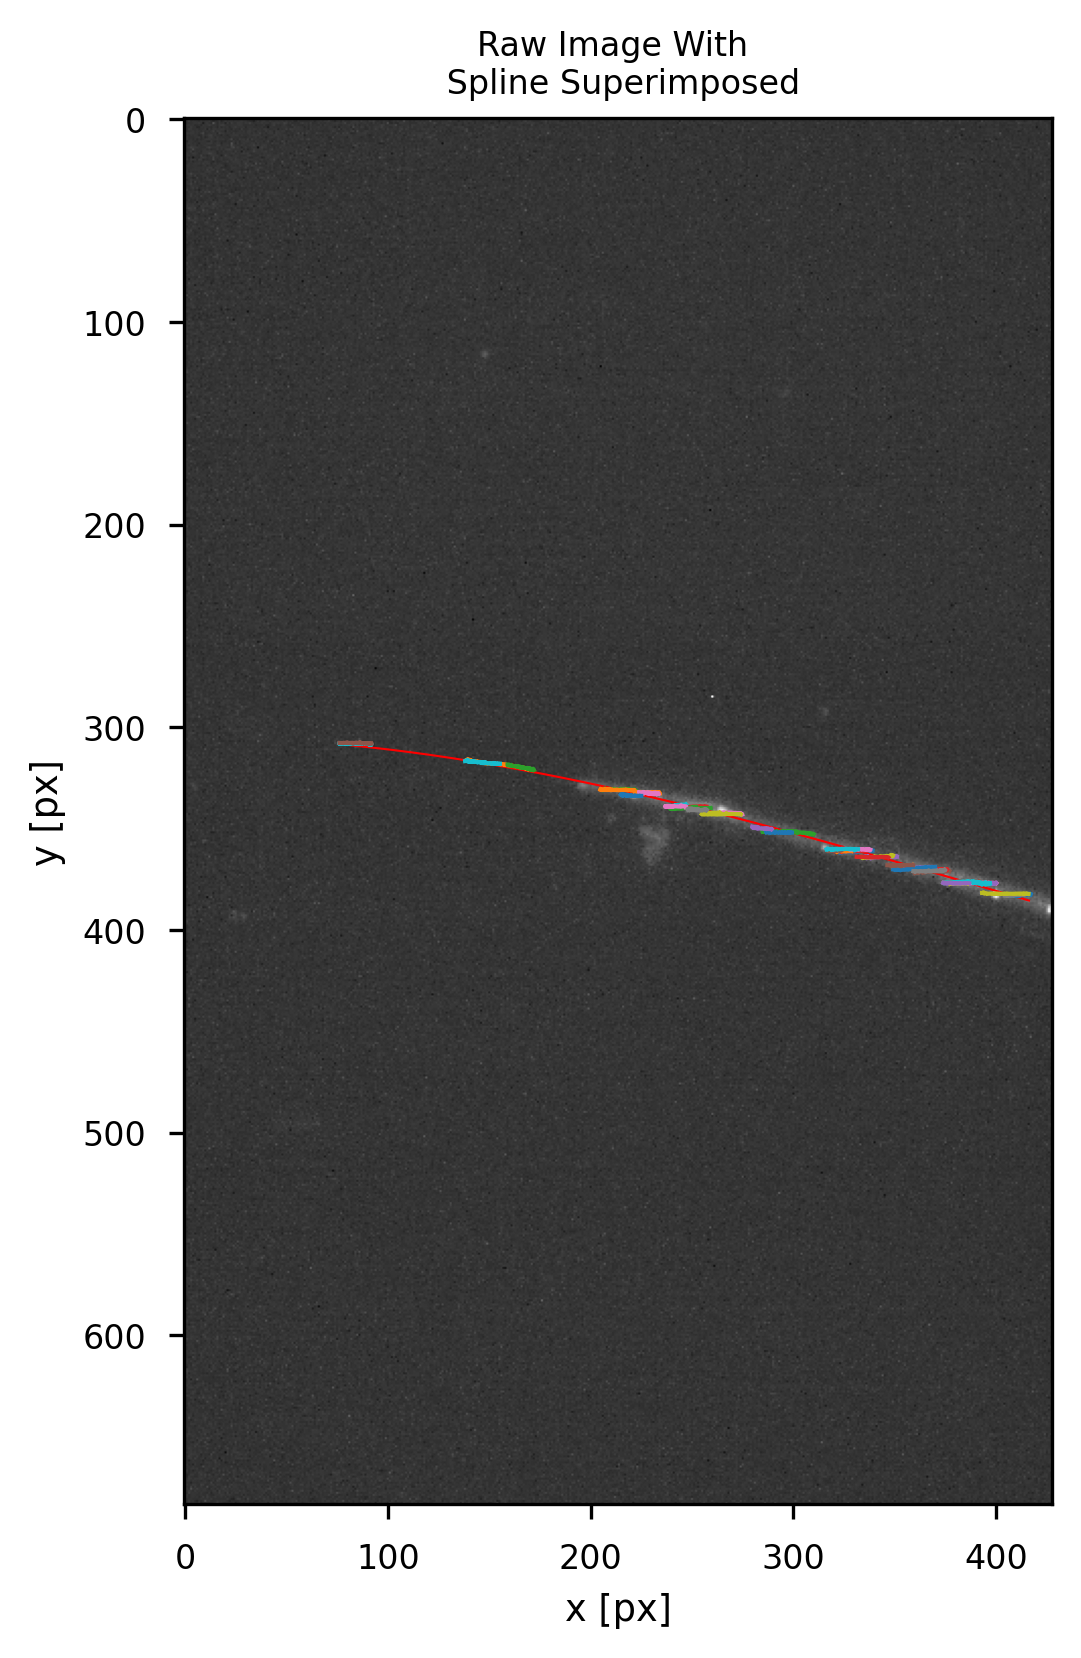

In [6]:
base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\21-02-2023\Untreated_Sample')
file_path = base_path.joinpath(r'Slides\Slide_1\21-Feb-23_TIRF473-7.tif')
tracks_path =r'C:\Warwick\Code\Image_Analysis\Jupyter-Notebooks\Filament_Axes\22-02-2023\Analysis\21_Feb_23_TIRF473-7\tracks\21-Feb-23_TIRF473-7.csv'





# Create a SimpleSpline object containing the filament axis
axis = SimpleSpline.from_csv(Path('splines\spline_0.txt'), 0.01)

spline_top = axis.shift_spline(.5)
spline_top = spline_top[1000:-1000,:]


@pims.pipeline
def green_channel(frame):
    return frame[:,0:428]

both_channels = pims.open(file_path.as_posix())

# Apply pipeline
images_green = green_channel(both_channels)


df = pd.read_csv(tracks_path)
#df = df[df['x']< 450] # some noisy or suspicious trajectories after 450

# Visualise the spline
with plt.style.context('seaborn-v0_8-paper'):
    fig , ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
    ylim = (images_green[0].shape[0],200)
    ax.imshow(-images_green[0], cmap='Greys')
    ax.plot(spline_top[:,0], spline_top[:,1], color='red', linewidth = 0.5)
    ax.set_title('Raw Image With \n Spline Superimposed', fontsize=8)
    tp.plot_traj(df)
    plt.show()


In [7]:
spline_top_fit = UnivariateSpline(spline_top[:,0], spline_top[:,1],k=5)
x_axis = np.arange(spline_top[0,0], spline_top[-1,0], 0.01)
spline_top_obj = SimpleSpline(0.01, x_axis, spline_top_fit(x_axis), spline_top_fit.derivative(), spline_object=spline_top_fit)

df[['height', 'distance']] = df.apply(lambda row: pd.Series(spline_top_obj.transform_coordinates(
        row['x'], row['y'], distance_from='head'), index=['height', 'distance']), axis=1)

df_cropped = df.groupby('particle').filter(lambda group: (group['height'].min() < -2) & (group['height'].max() > 2))

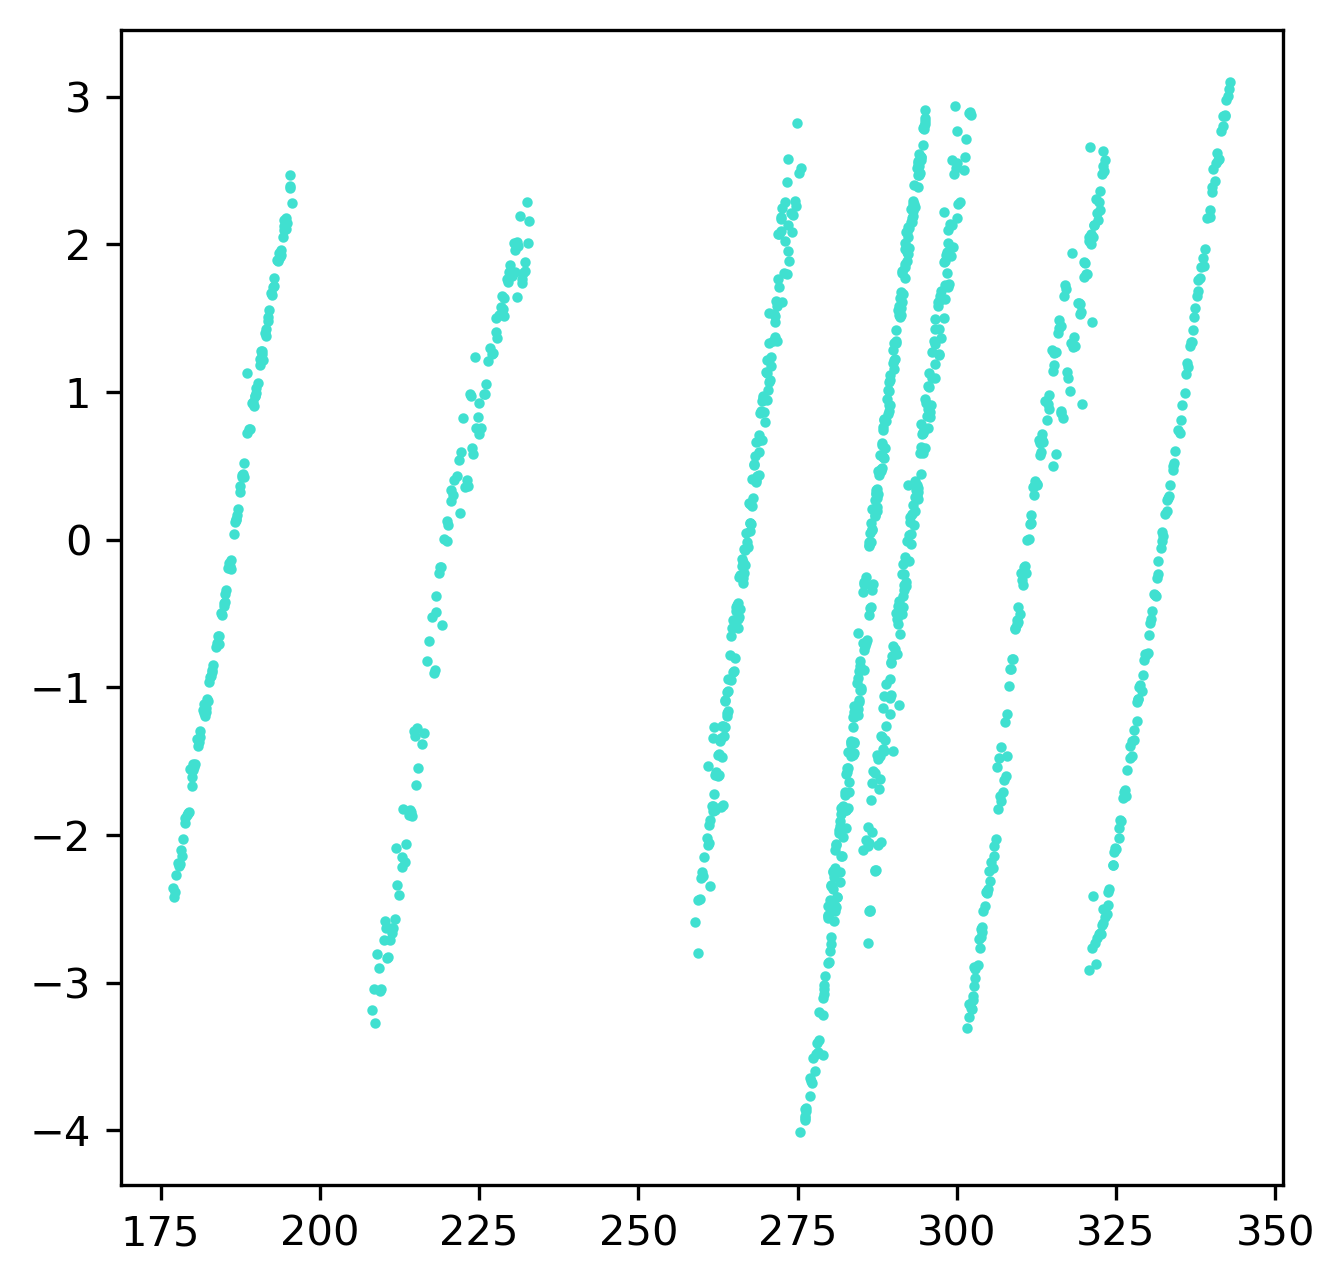

In [8]:
fig, ax = plt.subplots(1,1, figsize = (5,5), dpi=300)
test = df_cropped.dropna()

#test = test[test['angle']>27]
for k,particle in enumerate(test['particle'].unique()):
    x = test.loc[ test['particle'] == particle]['distance']
    y =  test.loc[ test['particle'] == particle]['height']

    ax.plot(x[::1], y[::1], '.', color='turquoise', markersize=3)


plt.show()

In [9]:
df_cropped.to_csv(f'tracks/{file_path.stem}_filtered.csv', index=False)